In [ ]:
########################################################################### START ###########################################################################
# Access to Drive
# Modules
# Data import
# DataFrames

## Gives access to the Drive
from google.colab import drive
drive.mount('/content/drive')

## Modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2

import sys, os
from pathlib import Path
import shutil
import glob
import itertools

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications.xception import preprocess_input 

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, TerminateOnNaN, EarlyStopping

from tensorflow.keras.utils import Sequence
from collections import Counter
from sklearn.utils.class_weight import compute_class_weight

from keras.models import load_model
from sklearn.metrics import classification_report, confusion_matrix

sys.path.append('/content/drive/MyDrive/Leukopy')
import leukopy_lib as leuko
from importlib import reload

reload(leuko)

## GPU status verification
tf.test.gpu_device_name()

## GPU type verification
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Mounted at /content/drive
Thu Sep 30 11:17:30 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.63.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P0    33W / 250W |    345MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                              

In [ ]:
########################################################################### DATAFRAME

## Need to copy all the files on the local computer
!cp -r "/content/drive/MyDrive/Leukopy/data/main_dataset.zip" .
!unzip main_dataset.zip

## Create the original dataframes 
path = Path('/content/main_dataset/')

df_train = leuko.generate_images_df(path/'training_set')
df_test = leuko.generate_images_df(path/'testing_set')
df_valid = leuko.generate_images_df(path/'validation_set')

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
  inflating: main_dataset/training_set/SNE_390822.jpg  
  inflating: main_dataset/training_set/PLATELET_967945.jpg  
  inflating: main_dataset/training_set/ERB_335809.jpg  
  inflating: main_dataset/training_set/MY_692958.jpg  
  inflating: main_dataset/training_set/PLATELET_273514.jpg  
  inflating: main_dataset/training_set/ERB_143620.jpg  
  inflating: main_dataset/training_set/MO_767746.jpg  
  inflating: main_dataset/training_set/MMY_117680.jpg  
  inflating: main_dataset/training_set/MO_429133.jpg  
  inflating: main_dataset/training_set/BNE_152051.jpg  
  inflating: main_dataset/training_set/EO_225257.jpg  
  inflating: main_dataset/training_set/PLATELET_843809.jpg  
  inflating: main_dataset/training_set/LY_288197.jpg  
  inflating: main_dataset/training_set/MY_299417.jpg  
  inflating: main_dataset/training_set/EO_163905.jpg  
  inflating: main_dataset/training_set/MY_14468.jpg  
  inflating: main_da

In [ ]:
def choose_classes(df_train, df_test, df_valid, n_classes = 12):

  # Option à 11 classes, sans les BL
  if n_classes == 11:
    df_train = df_train[df_train["label"] != "BL"]
    df_test = df_test[df_test["label"] != "BL"]
    df_valid = df_valid[df_valid["label"] != "BL"]

  # Option à 8 classes (IG, SNE), sans les BL :
  if n_classes == 8:
    df_train = df_train[df_train["label"] != "BL"]
    df_test = df_test[df_test["label"] != "BL"]
    df_valid = df_valid[df_valid["label"] != "BL"]

    df_train["label"] = df_train["label_2"]
    df_test["label"] = df_test["label_2"]
    df_valid["label"] = df_valid["label_2"]

  # Option à 9 classes (IG, SNE, BL)
  if n_classes == 9:
    df_train["label"] = df_train["label_2"]
    df_test["label"] = df_test["label_2"]
    df_valid["label"] = df_valid["label_2"]

  return n_classes, df_train, df_test, df_valid

n_classes, df_train, df_test, df_valid = choose_classes(df_train, df_test, df_valid, n_classes = 11)

In [ ]:
df_train["label"].value_counts()

EO     2352
PLT    1743
SNE    1263
BNE    1212
ERB    1162
MO     1068
LY      946
BA      903
MY      833
MMY     734
PMY     461
Name: label, dtype: int64

In [ ]:
########################################################################### Génération d'images ###########################################################################

batch_size = 32
img_height  = 360
img_width = 360

train_generator = ImageDataGenerator(rotation_range = 90,
                                     horizontal_flip = True, 
                                     vertical_flip = True)
valid_generator = ImageDataGenerator()
test_generator = ImageDataGenerator()

# Resize pictures, batchs from dataframe
training_set = train_generator.flow_from_dataframe(df_train, 
                                                   directory = None, # utilise x_col
                                                   x_col = 'img_path', 
                                                   y_col = 'label',
                                                   target_size = (img_height, img_width), 
                                                   color_mode = 'rgb',
                                                   classes = None,   # utilise y_col
                                                   class_mode = 'categorical', 
                                                   batch_size = batch_size,
                                                   shuffle = True, 
                                                   preprocessing_function = preprocess_input)

validation_set = valid_generator.flow_from_dataframe(df_valid, 
                                                     directory = None, # utilise x_col
                                                     x_col = 'img_path', 
                                                     y_col = 'label',
                                                     target_size = (img_height, img_width), 
                                                     color_mode = 'rgb',
                                                     classes = None,   # utilise y_col
                                                     class_mode = 'categorical', 
                                                     batch_size = batch_size, 
                                                     shuffle = True,
                                                     preprocessing_function = preprocess_input)

testing_set = test_generator.flow_from_dataframe(df_test, 
                                                 directory = None, # utilise x_col
                                                 x_col = 'img_path', 
                                                 y_col = 'label',
                                                 target_size = (img_height, img_width),
                                                 color_mode = 'rgb',
                                                 classes = None,   # utilise y_col
                                                 class_mode = 'categorical', 
                                                 batch_size = batch_size, 
                                                 shuffle = False, 
                                                 preprocessing_function = preprocess_input)

# Labels/Index connection :
label_map = training_set.class_indices
print('Train :', training_set.class_indices)
print('Valid :', validation_set.class_indices)
print('Test  :', testing_set.class_indices)

Found 12677 validated image filenames belonging to 11 classes.
Found 1730 validated image filenames belonging to 11 classes.
Found 2544 validated image filenames belonging to 11 classes.
Train : {'BA': 0, 'BNE': 1, 'EO': 2, 'ERB': 3, 'LY': 4, 'MMY': 5, 'MO': 6, 'MY': 7, 'PLT': 8, 'PMY': 9, 'SNE': 10}
Valid : {'BA': 0, 'BNE': 1, 'EO': 2, 'ERB': 3, 'LY': 4, 'MMY': 5, 'MO': 6, 'MY': 7, 'PLT': 8, 'PMY': 9, 'SNE': 10}
Test  : {'BA': 0, 'BNE': 1, 'EO': 2, 'ERB': 3, 'LY': 4, 'MMY': 5, 'MO': 6, 'MY': 7, 'PLT': 8, 'PMY': 9, 'SNE': 10}


In [ ]:
######## Utilitaire : sauvegarde des df
def print_dataframe(df, file_path):
  df.to_csv(path_or_buf = file_path, 
            sep = ',',
            header = True,
            index = True, 
            index_label = None)
  return

In [ ]:
import matplotlib.cm as cm
def get_img_array(img_path, size):
  img = tf.keras.preprocessing.image.load_img(img_path, target_size = size)
  array = tf.keras.preprocessing.image.img_to_array(img)
  array = np.expand_dims(array, axis = 0)
  array = preprocess_input(array)   # Penser à ajouter
  return array

def make_heatmap(img_array, model, last_conv_layer, class_index):

  grad_model = tf.keras.models.Model([model.inputs], [last_conv_layer.output, model.output])
  with tf.GradientTape() as tape:
    last_conv_layer_output, preds = grad_model(img_array)
    class_channel = preds[:, class_index]

  grads = tape.gradient(class_channel, last_conv_layer_output)
  pooled_grads = tf.reduce_mean(grads, axis = (0, 1, 2))

  heatmap_tmp = last_conv_layer_output[0].numpy()

  for i in range(last_conv_layer_output.shape[3]):
    heatmap_tmp[:,:,i] *= pooled_grads[i]
  heatmap = np.mean(heatmap_tmp, axis=-1)
  return heatmap

def gradcam(model, img_path, img_height, img_width, class_index = None, alpha = 0.5, plot = True):

  # Détecte la dernière couche de convolution (pas terrible : il faudrait sélectionner sur le type, pas sur le nom) :
  for layer in reversed(model.layers):
    if 'conv' in layer.name:
      last_conv_layer = model.get_layer(layer.name)
      break

  # Chargement + mise en forme de l'image :
  img_array = get_img_array(img_path, size = (img_height, img_width))

  # Choix de la classe à représenter :
  if class_index == None :
    # Désactiver Sotfmax sur la couche de sortie :
    model.layers[-1].activation = None
    # Prédiction + classe la plus probable :
    predict = model.predict(img_array)
    class_index = np.argmax(predict[0])

  # Calcul de la CAM : resize pour comparaison avec l'image finale
  heatmap = make_heatmap(img_array, model, last_conv_layer, class_index)
  big_heatmap = heatmap
  #big_heatmap = cv2.resize(heatmap, dsize = (img_height, img_width), interpolation = cv2.INTER_CUBIC)

  ## Traitement de la Heatmap
  # 1/ Normalisation
  big_heatmap = big_heatmap/big_heatmap.max()
  # 2/ On passe dans ReLu, pour flinguer les valeurs négatives
  big_heatmap = np.maximum(0, big_heatmap)
  
  ## Superposition de l'image et de la Heatmap 
  # 1/ Import de l'image d'origine
  img = tf.keras.preprocessing.image.load_img(img_path)
  img = tf.keras.preprocessing.image.img_to_array(img)

  # 2/ Rescale heatmap: 0-255
  big_heatmap = np.uint8(255*big_heatmap)

  # 3/ Jet colormap
  jet = cm.get_cmap("jet")

  # 4/ Use RGB values of the colormap
  jet_colors = jet(np.arange(256))[:, :3]
  jet_heatmap = jet_colors[big_heatmap]
  
  # 5/ Create an image with RGB colorized heatmap
  jet_heatmap = tf.keras.preprocessing.image.array_to_img(jet_heatmap)
  jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
  jet_heatmap = tf.keras.preprocessing.image.img_to_array(jet_heatmap)

  # 6/ Superimpose the heatmap on original image
  superimposed_img = jet_heatmap*alpha + img
  superimposed_img = tf.keras.preprocessing.image.array_to_img(superimposed_img)

  if plot == True:
    # 7/ Affichage des résultats
    fig = plt.figure(figsize = (8,8))
    fig.add_subplot(1,2,1)
    plt.imshow(big_heatmap)

    fig.add_subplot(1,2,2)
    plt.imshow(superimposed_img)
    plt.title("Chosen class : "+str(list(label_map.keys())[class_index]))

  # Réactive softmax si elle a été désactivée plus haut :
  if class_index == None :
    model.layers[-1].activation = 'softmax'

  return big_heatmap, superimposed_img

In [ ]:
# Calcul des poids pour compenser le déséquilibre des classes

def compute_weights(method = 3):

  if method == 1:
    counter = Counter(training_set.classes)     
    class_weights = {class_id : float(max(counter.values()))/num_images for class_id, num_images in counter.items()} 
    return class_weights

  if method == 2:
    class_weights = compute_class_weight(class_weight = 'balanced',
                                         classes = np.unique(training_set.classes),
                                         y = training_set.classes)
    class_weights = dict(enumerate(class_weights))
    return class_weights

  counter = Counter(training_set.classes)                          
  class_weights = {class_id : (1/num_images)*float(sum(counter.values()))/2 for class_id, num_images in counter.items()} 
  return class_weights

In [ ]:
########################################################################### MODEL - FUNC. ###########################################################################

# Model (Functional API)
inputs = layers.Input(shape = (img_height,img_width,3))
base_model = Xception(include_top = False,
                      weights = "imagenet",
                      input_tensor = inputs,
                      input_shape = (img_height,img_width,3),
                      pooling = 'avg')
base_model.training = False 
base_output = base_model.output
x = layers.Dense(units = 2048, activation = 'relu', name = 'dense_1')(base_output)
x = layers.Dropout(rate = 0.2, name = 'dropout_1')(x)
x = layers.Dense(units = 1024, activation = 'relu', name = 'dense_2')(x)
x = layers.Dropout(rate = 0.2, name = 'dropout_2')(x)
x = layers.Dense(units = 512, activation = 'relu', name = 'dense_3')(x)
x = layers.Dropout(rate = 0.2, name = 'dropout_3')(x)
outputs = layers.Dense(units = n_classes, activation = 'softmax', name = 'final_softmax')(x)
model = tf.keras.Model(inputs, outputs)

# Freeze EfficientNet
base_model.trainable = False

# Compile
optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-4)
model.compile(optimizer = optimizer, 
              loss = "categorical_crossentropy",
              metrics = ["accuracy"])

83689472/83683744 [==============================] - 1s 0us/step


In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 360, 360, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 179, 179, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 179, 179, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 179, 179, 32) 0           block1_conv1_bn[0][0]            
______________________________________________________________________________________________

In [ ]:
# Callbacks
TON = TerminateOnNaN()

control_lr = ReduceLROnPlateau(monitor = 'val_loss',
                               factor = 0.1, patience = 2, verbose = 1, mode = 'min', min_lr = 1e-6)
  
early_stopping = EarlyStopping(monitor = "val_loss", patience = 3, mode = 'min', restore_best_weights = True)

callbacks_list = [TON, control_lr, early_stopping]
                    
## Compute weights :
class_weights = compute_weights(method = 3)

## Training :
epochs = 100
training_history = model.fit(x = training_set, 
                             epochs = epochs,
                             callbacks = callbacks_list, 
                             validation_data = validation_set, 
                             class_weight = class_weights)

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
Epoch 1/40
397/397 [==============================] - 370s 887ms/step - loss: 36.5606 - accuracy: 0.2003 - val_loss: 1.9626 - val_accuracy: 0.2942
Epoch 2/40
397/397 [==============================] - 362s 911ms/step - loss: 12.3421 - accuracy: 0.2614 - val_loss: 1.8401 - val_accuracy: 0.3081
Epoch 3/40
397/397 [==============================] - 362s 913ms/step - loss: 11.0993 - accuracy: 0.2967 - val_loss: 1.7797 - val_accuracy: 0.3208
Epoch 4/40
397/397 [==============================] - 358s 901ms/step - loss: 10.4308 - accuracy: 0.3258 - val_loss: 1.6719 - val_accuracy: 0.3902
Epoch 5/40
397/397 [==============================] - 359s 905ms/step - loss: 10.0928 - accuracy: 0.3443 - val_loss: 1.7195 - val_accuracy: 0.3688
Epoch 6/40
397/397 [==============================] - 354s 893ms/step - loss: 9.7515 - accuracy: 0.3651 - val_loss: 1.6083 - va

In [ ]:
## Sauvegarde :
model.save("/content/drive/MyDrive/Leukopy/Xception_TL_11/model_fullsave")

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Leukopy/Xception_TL_11/model_fullsave/assets


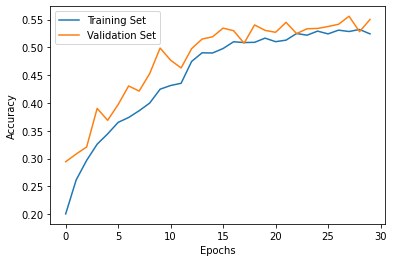

In [ ]:
training_accuracy = training_history.history['accuracy']
validation_accuracy = training_history.history['val_accuracy']

plt.figure()
plt.plot(np.arange(early_stopping.stopped_epoch), training_accuracy[0:early_stopping.stopped_epoch], label = 'Training Set')
plt.plot(np.arange(early_stopping.stopped_epoch), validation_accuracy[0:early_stopping.stopped_epoch], label = 'Validation Set')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
## Évaluation sur les données de test :
model.evaluate(testing_set)

80/80 [==============================] - 14s 169ms/step - loss: 1.2129 - accuracy: 0.5790


[1.212869644165039, 0.5790094137191772]

In [ ]:
########################################################################### ANALYSE #################################################################################################

In [ ]:
# Ne pas ré-entraîner, utiliser les poids déjà sauvegardés sur le drive

model = tf.keras.models.load_model("/content/drive/MyDrive/Leukopy/Xception_TL_11/model_fullsave")

In [ ]:
model.evaluate(testing_set)

80/80 [==============================] - 34s 207ms/step - loss: 1.2129 - accuracy: 0.5790


[1.2128695249557495, 0.5790094137191772]

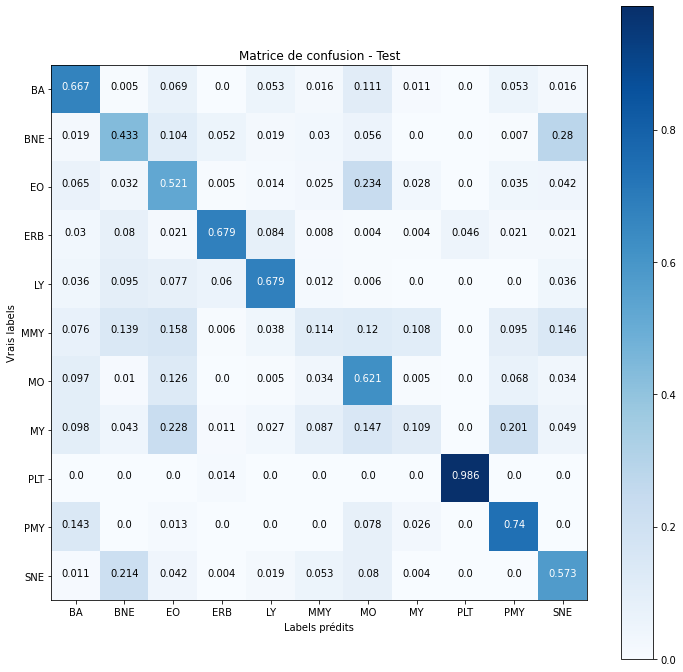

Classification Report - Test


precision    recall  f1-score support
BA   0.533898  0.666667  0.592941     189
BNE  0.456693  0.432836  0.444444     268
EO   0.578406  0.520833  0.548112     432
ERB  0.821429  0.679325  0.743649     237
LY   0.662791  0.678571  0.670588     168
MMY  0.222222  0.113924  0.150628     158
MO   0.376471  0.621359  0.468864     206
MY   0.357143  0.108696  0.166667     184
PLT   0.97019  0.986226  0.978142     363
PMY  0.367742   0.74026  0.491379      77
SNE  0.506757  0.572519  0.537634     262

In [ ]:
### 1 -- Rapport de classification :
def print_classification_report(testing_set, labels, title):

  # Prédiction : utilise le jeu de test (testing_set)
  predictions = model.predict(testing_set)
  y_pred = tf.argmax(predictions, axis = 1)

  # Calcul et affichage de la matrice de confusion
  cnf_matrix = confusion_matrix(testing_set.classes, y_pred, normalize = 'true')
  classes = range(len(labels))
  
  plt.figure(figsize = (12,12))
  plt.imshow(cnf_matrix, interpolation = 'nearest', cmap = 'Blues')
  plt.title("Matrice de confusion - "+title)
  plt.colorbar()

  tick_marks = np.arange(len(labels))
  plt.xticks(tick_marks, labels)
  plt.yticks(tick_marks, labels)

  for i, j in itertools.product(range(cnf_matrix.shape[0]), 
                                range(cnf_matrix.shape[1])):
    plt.text(j, i, np.around(cnf_matrix[i, j], decimals = 3),
             horizontalalignment = "center",
             color = "white" if cnf_matrix[i, j] > ( cnf_matrix.max() / 2) else "black")

  plt.ylabel('Vrais labels')
  plt.xlabel('Labels prédits')
  plt.show()

  # Rapport de classification 
  report = classification_report(testing_set.classes, y_pred, target_names = labels, output_dict = True)

  df_report = pd.DataFrame(index = list(report.keys())[:-3], columns = list(report["BA"].keys()))
  for key in list(report.keys())[:-3]:
    for column in list(report["BA"].keys()):
      df_report.loc[key, column] = report[key][column]
  
  print("Classification Report - "+title)
  return y_pred, display(df_report), 


## Bilan sur les données de test :
y_pred, df_report = print_classification_report(testing_set, label_map, title = "Test")

In [ ]:
### 2 - DF avec le résultat et le label de toutes les images du test :
df_results = pd.DataFrame(data = {"real":testing_set.classes,
                                  "pred":y_pred, 
                                  "img_path":df_test["img_path"]})

# Tri des images : mal classé (df_false), bien classé (df_true):
df_false = df_results[df_results["real"] != df_results["pred"]].reset_index(drop = True)
df_true = df_results[df_results["real"] == df_results["pred"]].reset_index(drop = True)


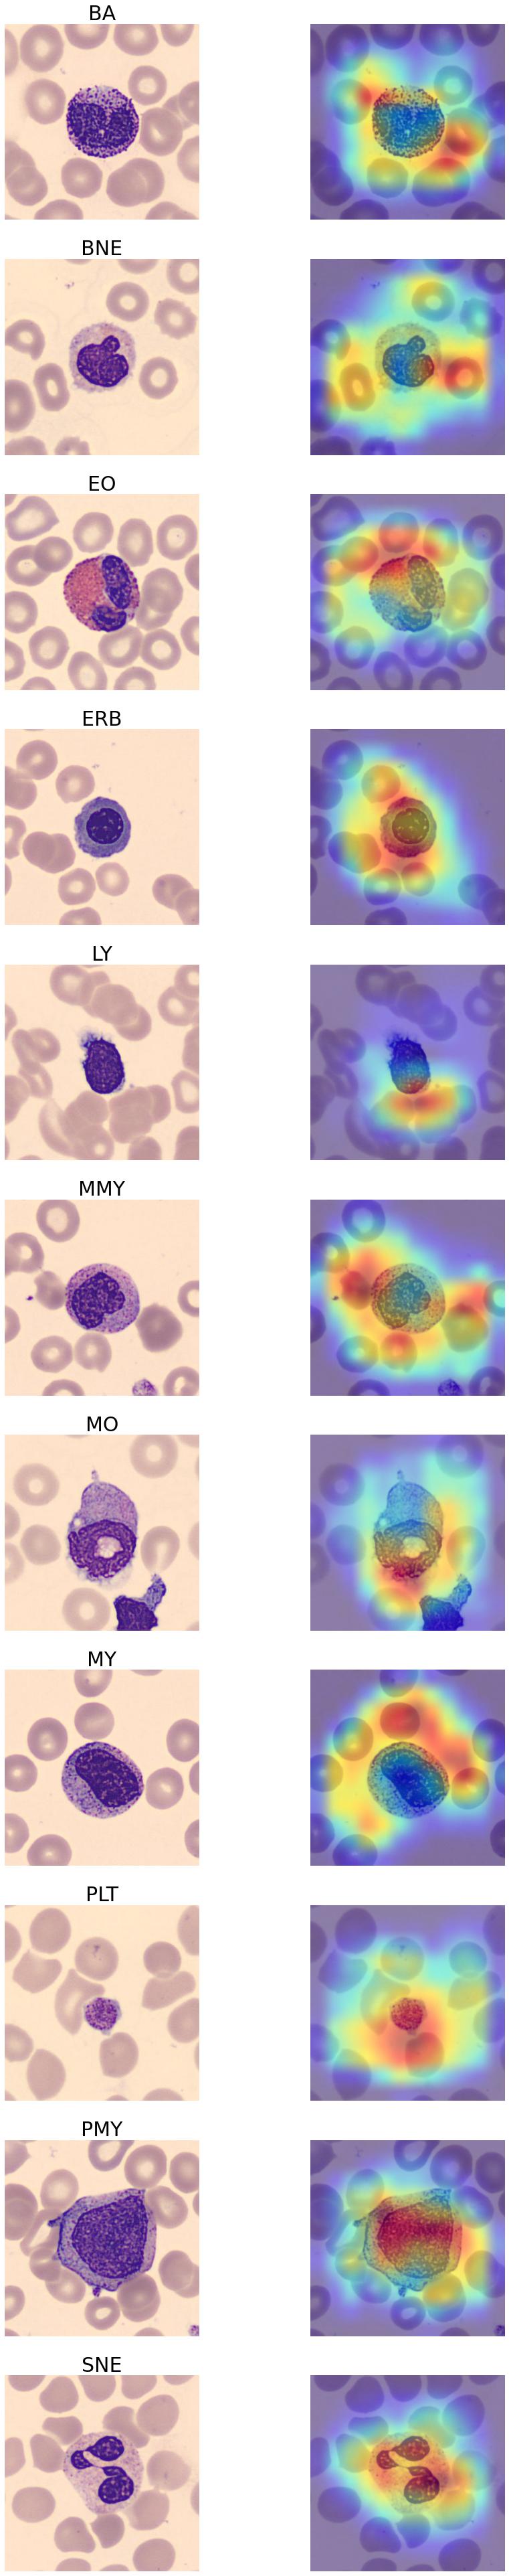

In [ ]:
### 3 -- Grad-CAM sur les images bien classées :

fig = plt.figure(figsize = (15, 70))
i = 0

for cell_class in range(n_classes):
  df_temp = df_true[df_true["real"] == cell_class]
  id = np.random.choice(df_temp.index, size = 1, replace = False)
  img_path = df_true.loc[id[0],"img_path"]
 
  big_heatmap, superimposed_img = gradcam(model, img_path, img_height, img_width, 
                                          class_index = None, alpha = 0.8, plot = False)

  fig.add_subplot(n_classes,2,i+1)
  plt.imshow(plt.imread(img_path))
  plt.title(list(label_map.keys())[cell_class], fontsize = 30)
  plt.grid(None)
  plt.axis('off')

  fig.add_subplot(n_classes,2,i+2)
  plt.imshow(superimposed_img)
  plt.grid(None)
  plt.axis('off')

  i += 2

plt.savefig("/content/drive/MyDrive/Leukopy/Xception_TL_11/xcep_gradcam")

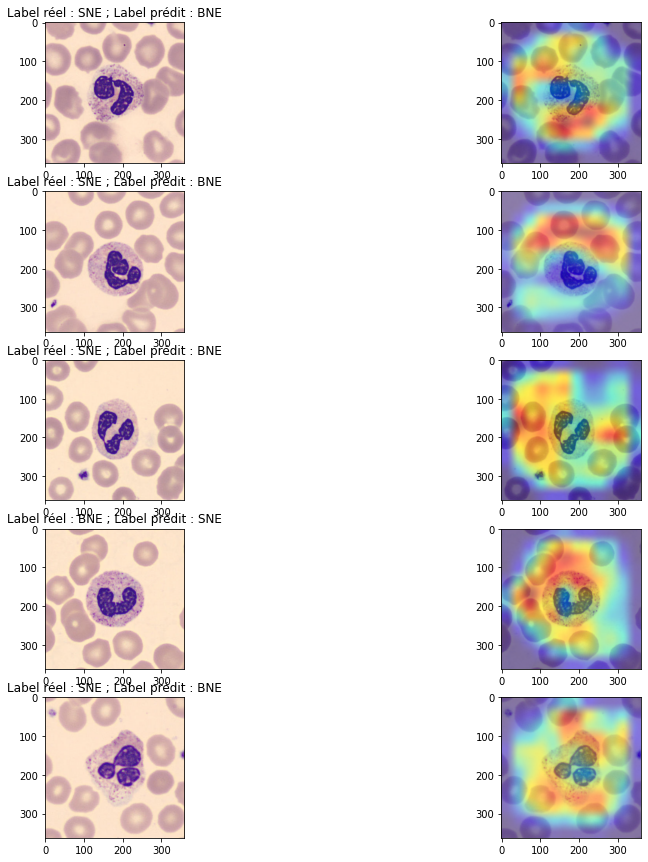

In [ ]:
### 4 -- Exemples d'images mal classées :
# Exemple : Confusion BNE/SNE : labels 1 et 10

conf_bne_sne = df_false[((df_false["real"] == 1) & (df_false["pred"] == 10)) | ((df_false["real"] == 10) & (df_false["pred"] == 1))]

i = 0

fig = plt.figure(figsize = (15,15))

for id in np.random.choice(conf_bne_sne.index, size = 5, replace = False):
  img_path = conf_bne_sne.loc[id,"img_path"]

  big_heatmap, superimposed_img = gradcam(model, img_path, img_height, img_width, 
                                          class_index = None, alpha = 0.8, plot = False)

  fig.add_subplot(5,2,i+1)
  plt.imshow(plt.imread(img_path))
  plt.title("Label réel : %s ; Label prédit : %s"%(list(label_map.keys())[conf_bne_sne.loc[id,"real"]],
                                                   list(label_map.keys())[conf_bne_sne.loc[id,"pred"]]))
  
  fig.add_subplot(5,2,i+2)
  plt.imshow(superimposed_img)
  i = i + 2

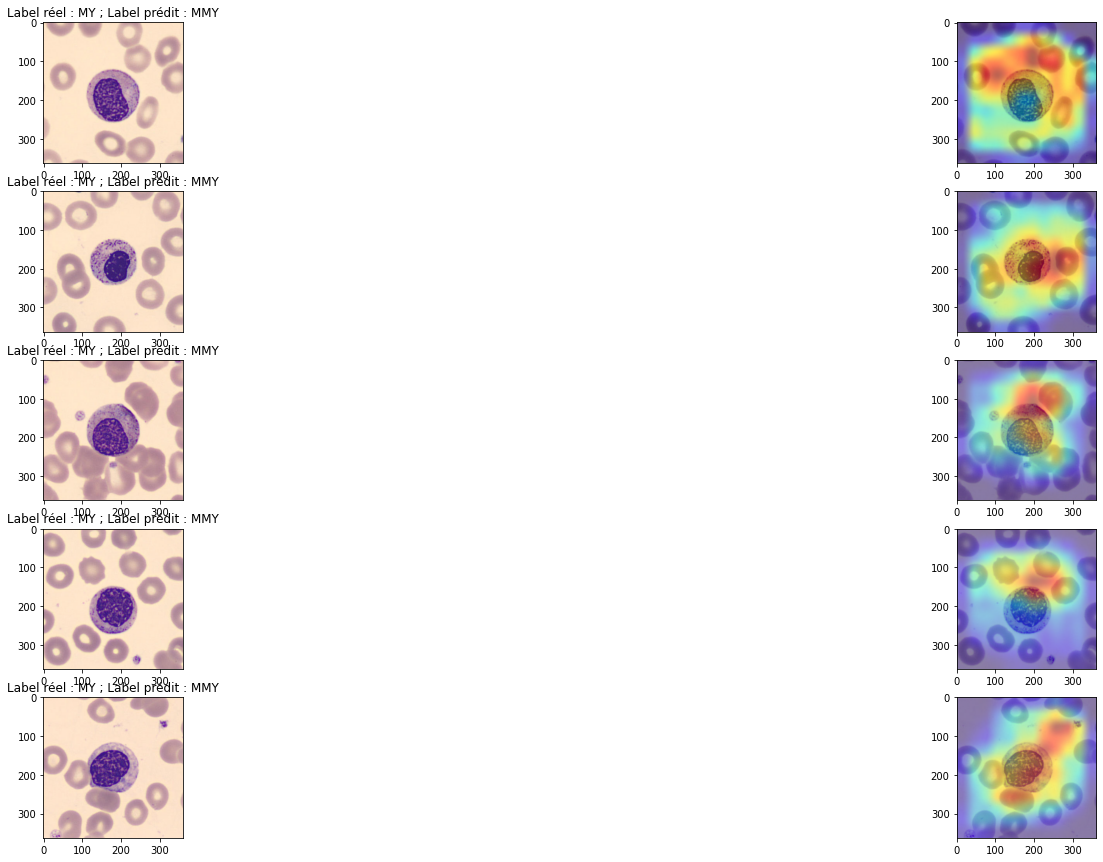

In [ ]:
# Exemple : Confusion MY/MMY : labels 5 et 7
conf_my_mmy = df_false[((df_false["real"] == 5) & (df_false["pred"] == 7)) | ((df_false["real"] == 7) & (df_false["pred"] == 5))]

fig = plt.figure(figsize = (30,15))
i = 0

for id in np.random.choice(conf_my_mmy.index, size = 5, replace = False):

  img_path = conf_my_mmy.loc[id,"img_path"]
  big_heatmap, superimposed_img = gradcam(model, img_path, img_height, img_width, 
                                          class_index = None, alpha = 0.8, plot = False)

  fig.add_subplot(5,2,i+1)
  plt.imshow(plt.imread(img_path))
  plt.title("Label réel : %s ; Label prédit : %s"%(list(label_map.keys())[conf_my_mmy.loc[id,"real"]],
                                                   list(label_map.keys())[conf_my_mmy.loc[id,"pred"]]))
  
  fig.add_subplot(5,2,i+2)
  plt.imshow(superimposed_img)
  i += 2